In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
import utils
from sklearn.metrics import confusion_matrix

plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 9b: Waterbody status and avlastningsbehov

Using Vann-Nett and NVE Atlas, I have manually identified the main rivers in each vassdragsområde around Trondheimsfjorden and extracted the downstream-most regine and waterbody IDs. I have included:

 * The main river in each vassdragsområde.
   
 * In cases where a vassdragsområde contains several significant rivers, I have included those with an upstream area >100 km2.

 * I have also included three smaller catchments specifically highlighted by Statsforvalteren (Hotranvassdraget, Hoplavassdraget and Lømsen-Langhammerelva). Note that these are all a bit small for TEOTIL3, so output must be interpreted with caution.

Results are stored in `trondheimsfjorden_major_rivers_by_vassom.xlsx`.

This notebook summarises model results, water quality status and avlastningsbehov for each of these catchments.

## 1. User options

In [3]:
# Vann-Nett data from notebook 9a
vn_csv = r"../data/vannnett_waterbody_status.csv"

# Excel file linking regine IDs to waterbodies
reg_xlsx = r"../data/trondheimsfjorden_major_rivers_by_vassom.xlsx"

# Summary Excel file to save
status_xlsx = r"../results/wfd_status_summary.xlsx"

# Whether to use time period from Vann-Nett or to fix them to a set period
use_vannnett_years = False
mod_st_yr, mod_end_yr = 2020, 2022

In [4]:
if use_vannnett_years and (mod_st_yr or mod_end_yr):
    print(
        "WARNING: 'use_vannnett_years' is True. 'mod_st_yr' and 'mod_end_yr' will be ignored."
    )

In [5]:
vn_df = pd.read_csv(vn_csv)
reg_df = pd.read_excel(reg_xlsx)
reg_df

,vassom,regine,waterbody_id,waterbody_name
0,120,120.2A10,120-63-R,Lena
1,120,120.4A1,120-40-R,Ingdalselva nedre del
2,121,121.A111,121-47-R,"Orkla, nedre del"
3,121,121.1A1,121-489-R,"Skjenaldelva, nedre del"
4,122,122.1A,122-72-R,"Børselva, nedre"
5,122,122.2A1,122-82-R,Vigda nederste del
6,122,122.A11,122-19-R,"Gaula, nedre del"
7,123,123.A11,123-29-R,Nidelva nedenfor Nedre Leirfoss
8,123,123.4A0,123-499-R,Homla
9,124,124.A12,124-72-R,Stjørdalselva nedre del


In [6]:
# Water quality elements of interest
quality_element = "ecological"
element_list = ["Total nitrogen", "Total organic carbon", "Total phosphorous"]

template_df = pd.DataFrame(
    {
        "parameter": element_list,
        "unit": ["µg/l", "mg/l", "µg/l"],
    }
).set_index("parameter")

vn_cols = [
    "status",
    "value",
    "reference_value",
    "status_limits",
    "year_from",
    "year_to",
]

df_list = []
for idx, row in reg_df.iterrows():
    vassom, reg_id, wb_id, wb_name = row
    vn_df = utils.get_data_from_vannnett(wb_id, quality_element=quality_element)

    if vn_df is not None:
        vn_df = vn_df.query("parameter in @element_list").set_index("parameter")
        del vn_df["unit"]
        vn_df = template_df.join(vn_df)
    else:
        vn_df = template_df.copy()
        vn_df[vn_cols] = np.nan

    vn_df["waterbody_id"] = wb_id
    vn_df["waterbody_name"] = wb_name
    vn_df["regine"] = reg_id
    vn_df = vn_df.reset_index()[
        ["regine", "waterbody_id", "waterbody_name", "parameter"] + vn_cols + ["unit"]
    ]
    df_list.append(vn_df)

vn_df = pd.concat(df_list, axis="rows").reset_index(drop=True)
vn_df["status"] = vn_df["status"].fillna("Undefined")
vn_df["status_limits"] = vn_df["status_limits"].fillna("")
vn_df["ges_thresh"] = vn_df["status_limits"].str.split(";", n=-1, expand=True)[1]
vn_df["ges_thresh"] = vn_df["ges_thresh"].astype(float)

if not use_vannnett_years:
    vn_df["year_from"] = mod_st_yr
    vn_df["year_to"] = mod_end_yr

vn_df.head()

,regine,waterbody_id,waterbody_name,parameter,status,value,reference_value,status_limits,year_from,year_to,unit,ges_thresh
0,120.2A10,120-63-R,Lena,Total nitrogen,High,323.37500,275.0,475.0;650.0;1075.0;1775.0,2020,2022,µg/l,650.0
1,120.2A10,120-63-R,Lena,Total organic carbon,Undefined,6.80625,NaN,,2020,2022,mg/l,NaN
2,120.2A10,120-63-R,Lena,Total phosphorous,High,15.68125,9.0,17.0;24.0;45.0;83.0,2020,2022,µg/l,24.0
3,120.4A1,120-40-R,Ingdalselva nedre del,Total nitrogen,High,335.00000,250.0,400.0;550.0;900.0;1500.0,2020,2022,µg/l,550.0
4,120.4A1,120-40-R,Ingdalselva nedre del,Total organic carbon,Undefined,7.05000,NaN,,2020,2022,mg/l,NaN


In [7]:
nve_data_year = 2023
st_yr, end_yr = 2013, 2022
result_csv = f"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/trondheimsfjorden_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"

# Pars to compare
par_dict = {
    "Total nitrogen": "totn",
    "Total phosphorous": "totp",
    "Total organic carbon": "toc",
}

In [8]:
# Read saved data
mod_df = pd.read_csv(result_csv)
base_df = mod_df.query("scenario == 'Baseline'").copy()
base_df.head()

,scenario,year,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,...,local_urban_totp_kg,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg
0,Baseline,2013,120.111,120.,294.041409,4724.995038,3.341540,7364.350432,75.858338,369.899747,...,29.0,11.6,123.1,6148.3,5.8,56685.2,1047.0,1170.1,33.4,27.6
1,Baseline,2013,120.1120,120.,105.272947,1936.771554,1.311753,2638.932168,29.436172,134.709119,...,1.8,0.7,26.2,1295.5,1.2,11962.9,224.8,251.0,7.1,5.9
2,Baseline,2013,120.112Z,120.,69.306927,91.185524,0.631110,1506.976561,19.288438,88.595366,...,0.0,0.0,60.0,2719.9,2.8,27274.7,511.1,571.1,16.3,13.5
3,Baseline,2013,120.11Z,120.,28.594557,18.969073,1.079797,1769.637270,10.153382,38.747939,...,0.0,0.0,158.4,6800.2,7.5,71711.6,1341.9,1500.3,43.0,35.5
4,Baseline,2013,120.12,120.,112.728112,1903.222957,1.298166,2577.829957,29.549642,142.277754,...,0.0,0.0,88.7,4250.9,4.2,39773.3,758.2,846.9,24.6,20.4


In [9]:
%%capture

# If the status limits are not set, it is probably because the waterbody type has not been
# officially approved in Vann-Nett. In this case, use default values below - see e-mail from
# Leif Inge received 28.11.2024
default_bnds_dict = {
    "totp": "20.0;29.0;58.0;98.0",
    "totn": "550.0;775.0;1325.0;2025.0",
    "toc": "",
}

human_srcs = [
    "agriculture_",
    "aquaculture_",
    "industry_",
    "large-wastewater_",
    "spredt_",
    "urban_",
]
pres_conc_list = []
pres_status_list = []
ref_conc_list = []
avlast_list = []
for idx, row in vn_df.iterrows():
    reg_id = row["regine"]
    par_name = row["parameter"]
    st_yr, end_yr = row["year_from"], row["year_to"]
    class_bnds = row["status_limits"]
    par = par_dict[par_name]
    cols = ["year", "accum_q_m3/s"] + [
        col
        for col in base_df.columns
        if (col.startswith("accum_") and f"_{par}_" in col)
    ]
    par_reg_df = base_df.query(
        "(regine == @reg_id) and (year >= @st_yr) and (year <= @end_yr)"
    )[cols].copy()
    par_reg_df.columns = [col.replace("accum_", "") for col in cols]
    par_reg_df["days_in_year"] = pd.to_datetime(
        par_reg_df["year"], format="%Y"
    ).dt.is_leap_year.apply(lambda x: 366 if x else 365)
    par_reg_df["flow_l"] = (
        par_reg_df["q_m3/s"] * 60 * 60 * 24 * par_reg_df["days_in_year"] * 1000
    )
    par_reg_df.drop(columns=["year", "days_in_year", "q_m3/s"])
    par_cols = [col for col in par_reg_df.columns if f"_{par}_" in col]
    human_cols = [
        col for col in par_reg_df.columns if any(src in col for src in human_srcs)
    ]
    unit_fac = 1e6 if par == "toc" else 1e9
    vol = par_reg_df["flow_l"].sum()
    tot = par_reg_df[par_cols].sum().sum()
    hum = par_reg_df[human_cols].sum().sum()
    nat = tot - hum

    pres_conc = tot * unit_fac / vol
    ref_conc = nat * unit_fac / vol

    if class_bnds == "":
        # Try using default bounds if available
        class_bnds = default_bnds_dict[par]

    if class_bnds != "":
        status = utils.get_wfd_class(class_bnds, pres_conc)
        ges_conc = float(class_bnds.split(";")[1])
    else:
        status = "Undefined"
        ges_conc = np.nan

    if par == "toc":
        ges_conc = ges_conc * 1000
    avlast_dict = teo.model.get_avlastningsbehov(
        reg_id,
        par.upper(),
        ges_conc,
        base_df.copy(),
        st_yr=st_yr,
        end_yr=end_yr,
        index_col="year",
    )

    pres_conc_list.append(pres_conc)
    ref_conc_list.append(ref_conc)
    pres_status_list.append(status)
    avlast_list.append(avlast_dict["reduction_target_pct"])

vn_df["value_mod"] = pres_conc_list
vn_df["reference_value_mod"] = ref_conc_list
vn_df["status_mod"] = pres_status_list
vn_df["avlastningsbehov_pct"] = avlast_list
vn_df

In [10]:
vn_df

,regine,waterbody_id,waterbody_name,parameter,status,value,reference_value,status_limits,year_from,year_to,unit,ges_thresh,value_mod,reference_value_mod,status_mod,avlastningsbehov_pct
0,120.2A10,120-63-R,Lena,Total nitrogen,High,323.37500,275.0,475.0;650.0;1075.0;1775.0,2020,2022,µg/l,650.0,406.439183,188.437536,High,-59.878715
1,120.2A10,120-63-R,Lena,Total organic carbon,Undefined,6.80625,NaN,,2020,2022,mg/l,NaN,7.247233,6.660021,Undefined,NaN
2,120.2A10,120-63-R,Lena,Total phosphorous,High,15.68125,9.0,17.0;24.0;45.0;83.0,2020,2022,µg/l,24.0,15.694436,3.400304,High,-52.875676
3,120.4A1,120-40-R,Ingdalselva nedre del,Total nitrogen,High,335.00000,250.0,400.0;550.0;900.0;1500.0,2020,2022,µg/l,550.0,286.163393,211.340180,High,-92.141631
4,120.4A1,120-40-R,Ingdalselva nedre del,Total organic carbon,Undefined,7.05000,NaN,,2020,2022,mg/l,NaN,8.846520,8.650600,Undefined,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,131.1A,131-8-R,Samløp Mossa-Skjerva,Total organic carbon,Undefined,NaN,NaN,,2020,2022,mg/l,NaN,6.177353,6.011374,Undefined,NaN
59,131.1A,131-8-R,Samløp Mossa-Skjerva,Total phosphorous,Undefined,NaN,NaN,,2020,2022,µg/l,NaN,7.001322,2.884295,High,-314.083520
60,132.A1,132-77-R,Skauga nedre del,Total nitrogen,High,200.00000,275.0,475.0;650.0;1075.0;1775.0,2020,2022,µg/l,650.0,409.632423,202.627505,High,-58.633919
61,132.A1,132-77-R,Skauga nedre del,Total organic carbon,Undefined,6.30000,NaN,,2020,2022,mg/l,NaN,6.864813,6.651453,Undefined,NaN


In [11]:
cols = [
    "regine",
    "waterbody_id",
    "waterbody_name",
    "parameter",
    "status",
    "status_mod",
    "value",
    "value_mod",
    "reference_value",
    "reference_value_mod",
    "ges_thresh",
    "unit",
    "avlastningsbehov_pct",
]
cols_to_round = [
    "value",
    "value_mod",
    "reference_value",
    "reference_value_mod",
    "ges_thresh",
    "avlastningsbehov_pct",
]
status_df = vn_df[cols].copy()
status_df[cols_to_round] = status_df[cols_to_round].round(1)
status_df["avlastningsbehov_pct"] = status_df["avlastningsbehov_pct"].clip(lower=0)

# Styling
style_dict = {
    "High": "#5893A9",
    "Good": "#6FB22C",
    "Moderate": "#FFF6A6",
    "Poor": "#F6A800",
    "Bad": "#E63D5C",
    "Undefined": "#D9D9D9",
}


def apply_color(val):
    return f'background-color: {style_dict.get(val, "#FFFFFF")}'


status_df_styled = status_df.style.map(apply_color, subset=["status", "status_mod"])
status_df_styled = status_df_styled.background_gradient(
    cmap="coolwarm", subset=["avlastningsbehov_pct"]
)

status_df_styled.to_excel(status_xlsx, index=False)

status_df_styled

,regine,waterbody_id,waterbody_name,parameter,status,status_mod,value,value_mod,reference_value,reference_value_mod,ges_thresh,unit,avlastningsbehov_pct
0,120.2A10,120-63-R,Lena,Total nitrogen,High,High,323.400000,406.400000,275.000000,188.400000,650.000000,µg/l,0.000000
1,120.2A10,120-63-R,Lena,Total organic carbon,Undefined,Undefined,6.800000,7.200000,nan,6.700000,nan,mg/l,nan
2,120.2A10,120-63-R,Lena,Total phosphorous,High,High,15.700000,15.700000,9.000000,3.400000,24.000000,µg/l,0.000000
3,120.4A1,120-40-R,Ingdalselva nedre del,Total nitrogen,High,High,335.000000,286.200000,250.000000,211.300000,550.000000,µg/l,0.000000
4,120.4A1,120-40-R,Ingdalselva nedre del,Total organic carbon,Undefined,Undefined,7.000000,8.800000,nan,8.700000,nan,mg/l,nan
5,120.4A1,120-40-R,Ingdalselva nedre del,Total phosphorous,High,High,8.400000,10.000000,8.000000,5.300000,20.000000,µg/l,0.000000
6,121.A111,121-47-R,"Orkla, nedre del",Total nitrogen,Undefined,High,nan,368.400000,nan,193.200000,nan,µg/l,0.000000
7,121.A111,121-47-R,"Orkla, nedre del",Total organic carbon,Undefined,Undefined,nan,4.800000,nan,4.500000,nan,mg/l,nan
8,121.A111,121-47-R,"Orkla, nedre del",Total phosphorous,Undefined,High,nan,9.600000,nan,4.600000,nan,µg/l,0.000000
9,121.1A1,121-489-R,"Skjenaldelva, nedre del",Total nitrogen,High,Good,220.000000,329.300000,200.000000,176.400000,475.000000,µg/l,0.000000


In [12]:
test = vn_df.query("(status != 'Undefined') and (status_mod != 'Undefined')")
print(len(test), "WFD status assignments.")
print((test["status"] == test["status_mod"]).sum())
print((test["status"] != test["status_mod"]).sum())
test

30 WFD status assignments.
22
8


,regine,waterbody_id,waterbody_name,parameter,status,value,reference_value,status_limits,year_from,year_to,unit,ges_thresh,value_mod,reference_value_mod,status_mod,avlastningsbehov_pct
0,120.2A10,120-63-R,Lena,Total nitrogen,High,323.375000,275.0,475.0;650.0;1075.0;1775.0,2020,2022,µg/l,650.0,406.439183,188.437536,High,-59.878715
2,120.2A10,120-63-R,Lena,Total phosphorous,High,15.681250,9.0,17.0;24.0;45.0;83.0,2020,2022,µg/l,24.0,15.694436,3.400304,High,-52.875676
3,120.4A1,120-40-R,Ingdalselva nedre del,Total nitrogen,High,335.000000,250.0,400.0;550.0;900.0;1500.0,2020,2022,µg/l,550.0,286.163393,211.340180,High,-92.141631
5,120.4A1,120-40-R,Ingdalselva nedre del,Total phosphorous,High,8.450000,8.0,14.0;20.0;36.0;68.0,2020,2022,µg/l,20.0,9.950671,5.319228,High,-100.932643
9,121.1A1,121-489-R,"Skjenaldelva, nedre del",Total nitrogen,High,220.000000,200.0,325.0;475.0;775.0;1350.0,2020,2022,µg/l,475.0,329.318426,176.351018,Good,-44.193806
11,121.1A1,121-489-R,"Skjenaldelva, nedre del",Total phosphorous,High,3.000000,6.0,11.0;17.0;30.0;60.0,2020,2022,µg/l,17.0,9.721892,3.213559,High,-74.810348
12,122.1A,122-72-R,"Børselva, nedre",Total nitrogen,Good,635.050000,325.0,550.0;775.0;1325.0;2025.0,2020,2022,µg/l,775.0,881.604245,207.473688,Moderate,12.112450
14,122.1A,122-72-R,"Børselva, nedre",Total phosphorous,High,19.450000,11.0,20.0;29.0;58.0;98.0,2020,2022,µg/l,29.0,40.644612,3.015604,Moderate,28.666367
15,122.2A1,122-82-R,Vigda nederste del,Total nitrogen,High,481.100000,325.0,550.0;775.0;1325.0;2025.0,2020,2022,µg/l,775.0,620.775350,174.522340,Good,-24.814939
17,122.2A1,122-82-R,Vigda nederste del,Total phosphorous,High,12.451000,11.0,20.0;29.0;58.0;98.0,2020,2022,µg/l,29.0,36.945333,2.932120,Moderate,21.523840


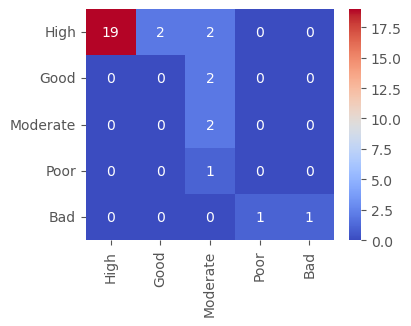

In [13]:
# Confusion matrix
classes = ["High", "Good", "Moderate", "Poor", "Bad"]
conf_matrix = confusion_matrix(test["status"], test["status_mod"], labels=classes)
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)
plt.figure(figsize=(4, 3))
sn.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="coolwarm")
plt.savefig(r"../results/images/confusion_matrix.png", dpi=200, bbox_inches="tight")

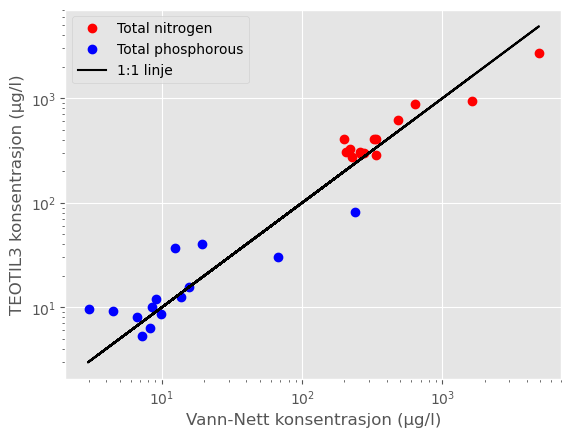

In [14]:
test = vn_df.query("value < 5000").copy()
test
plt.plot(
    test.query("parameter == 'Total nitrogen'")["value"],
    test.query("parameter == 'Total nitrogen'")["value_mod"],
    "ro",
    label="Total nitrogen",
)
plt.plot(
    test.query("parameter == 'Total phosphorous'")["value"],
    test.query("parameter == 'Total phosphorous'")["value_mod"],
    "bo",
    label="Total phosphorous",
)
plt.plot(test["value"], test["value"], "k-", label="1:1 linje")
plt.xlabel("Vann-Nett konsentrasjon (μg/l)")
plt.ylabel("TEOTIL3 konsentrasjon (μg/l)")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig(r"../results/images/vann-nett_vs_teotil3.png", dpi=200, bbox_inches="tight")